## Context
##### This data was collected in a personal attempt to identify more books that one would like, based on ones they may have read in the past. It comprises 10k of the most recommended books of all time.

##### This data was collected in an attempt to aid my Movies/Shows dataset to help with projects concerning cross-content analysis/recommendations for instance.

##### Please Upvote if this helps you!
##### Content
* Book - Name of the book. Soemtimes this includes the details of the Series it belongs to inside a parenthesis. This information can be further extracted to analyse only series.
* Author - Name of the book's Author
* Description - The book's description as mentioned on Goodreads
* Genres - Multiple Genres as classified on Goodreads. Could be useful for Multi-label classification or Content based recommendation and Clustering.
* Average Rating - The average rating (Out of 5) given on Goodreads
* Number of Ratings - The Number of users that have Ratings. (Not to be confused with reviews)
* URL - The Goodreads URL for the book's details' page

# Data Load/ Understanding

In [2]:
# base
import pandas as pd
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

# nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import warnings
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv("/kaggle/input/best-books-10k-multi-genre-data/goodreads_data.csv")
df.head()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


In [4]:
df.shape

(10000, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   10000 non-null  int64  
 1   Book         10000 non-null  object 
 2   Author       10000 non-null  object 
 3   Description  9923 non-null   object 
 4   Genres       10000 non-null  object 
 5   Avg_Rating   10000 non-null  float64
 6   Num_Ratings  10000 non-null  object 
 7   URL          10000 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB


In [6]:
df = df.dropna()

## Overall goals list:
* Perform simple EDA fro better understanding
* Create columns for each genres
* Preprocess Description column
* Create soup that contains Author, Description, Genres features

# 1-step: EDA with Preprocess

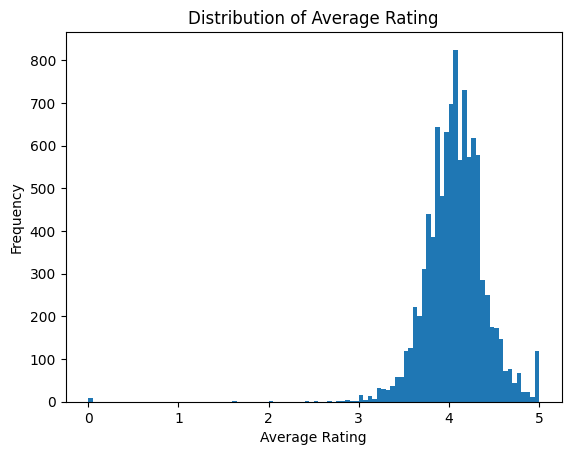

In [7]:
plt.hist(df['Avg_Rating'], bins = 100)
plt.title('Distribution of Average Rating')

plt.xlabel('Average Rating')
plt.ylabel('Frequency')

plt.show()

> "As we can see, the majority of votes fall between [3.8, 4.3]."

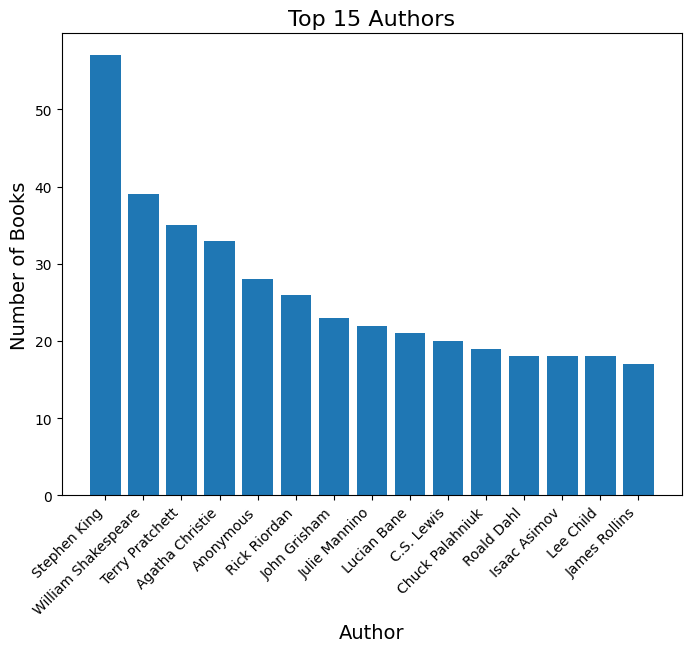

In [8]:
top_authors = df.groupby('Author').size().sort_values(ascending=False).head(15)
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(top_authors.index, top_authors.values)

ax.set_title('Top 15 Authors', fontsize=16)
ax.set_xlabel('Author', fontsize=14)
ax.set_ylabel('Number of Books', fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.show()

> The Stephen King is the most popular author

# 2-step : PreProcessing

In [9]:
import re
# Function for removing NonAscii characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting into lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Applying all the functions in description and storing as a cleaned_desc
df['cleaned_Desc'] = df['Description'].apply(_removeNonAscii)
df['cleaned_Desc'] = df.cleaned_Desc.apply(func = make_lower_case)
df['cleaned_Desc'] = df.cleaned_Desc.apply(func = remove_stop_words)
df['cleaned_Desc'] = df.cleaned_Desc.apply(func=remove_punctuation)
df['cleaned_Desc'] = df.cleaned_Desc.apply(func=remove_html)

# view
df.sample(5)

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL,cleaned_Desc
8017,8017,Double Identity,Margaret Peterson Haddix,So my only protection is a kindergarten teache...,"['Young Adult', 'Science Fiction', 'Fiction', ...",4.02,"16,186",https://www.goodreads.com/book/show/155370.Dou...,protection kindergarten teacher ninety eight p...
6129,6129,"Brown Bear, Brown Bear, What Do You See?",Bill Martin Jr.,"A big happy frog, a plump purple cat, a handso...","['Picture Books', 'Childrens', 'Animals', 'Fic...",4.25,"174,942",https://www.goodreads.com/book/show/759611.Bro...,big happy frog plump purple cat handsome blue ...
3237,3237,"The Sinner (Rizzoli & Isles, #3)",Tess Gerritsen,Not even the icy temperatures of a typical New...,"['Mystery', 'Thriller', 'Crime', 'Fiction', 'M...",4.13,"52,765",https://www.goodreads.com/book/show/32257.The_...,even icy temperatures typical new england wint...
9104,9104,Two Rivers Close To A Dream,Joel Schwan,Human souls course as rivers beneath starry mi...,[],5.00,6,https://www.goodreads.com/book/show/1402337.Tw...,human souls course rivers beneath starry minds...
4441,4441,The Beekeeper's Apprentice (Mary Russell and S...,Laurie R. King,"Long retired, Sherlock Holmes quietly pursues ...","['Mystery', 'Fiction', 'Historical Fiction', '...",4.05,"80,122",https://www.goodreads.com/book/show/91661.The_...,long retired sherlock holmes quietly pursues s...


In [10]:
# preProcess Author columns
df['cleaned_Author'] = df["Author"].apply(func = make_lower_case)
df['cleaned_Author'] = df["cleaned_Author"].apply(func = remove_stop_words)
df['cleaned_Author'] = df["cleaned_Author"].apply(func=remove_punctuation)
df['cleaned_Author'] = df.cleaned_Author.apply(func=remove_html)
df.sample(5)

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL,cleaned_Desc,cleaned_Author
9066,9066,Tom Clancy Presents: Act of Valor,Dick Couch,The Navy SEALs have been fighting terrorists a...,"['Fiction', 'Military Fiction', 'War', 'Thrill...",4.11,"3,504",https://www.goodreads.com/book/show/13381425-t...,navy seals fighting terrorists around world de...,dick couch
4968,4968,Dare: Accepting the Challenge of Trusting Lead...,Scott Weiss,Not Business as Usual In the current business ...,"['Leadership', 'Business', 'Contemporary', 'Ad...",4.19,107,https://www.goodreads.com/book/show/16145204-dare,business usual current business climate distru...,scott weiss
5546,5546,13 Little Blue Envelopes (Little Blue Envelope...,Maureen Johnson,"Inside little blue envelope 1 are $1,000 and i...","['Young Adult', 'Contemporary', 'Romance', 'Fi...",3.63,"82,009",https://www.goodreads.com/book/show/17020.13_L...,inside little blue envelope 1 1 000 instructio...,maureen johnson
734,734,Exotic Neurotic,Kenneth Jarrett Singleton,SYNOPSIS Exotic Neurotic is a book of poetry w...,"['Poetry', 'Contemporary', 'Fiction']",3.68,"2,443",https://www.goodreads.com/book/show/29395568-e...,synopsis exotic neurotic book poetry involves ...,kenneth jarrett singleton
5331,5331,Healing the Shame that Binds You,John Bradshaw,"“I used to drink,” writes John Bradshaw, “to s...","['Psychology', 'Self Help', 'Nonfiction', 'Men...",4.08,"10,398",https://www.goodreads.com/book/show/98399.Heal...,used drink writes john bradshaw solve problems...,john bradshaw


In [11]:
# Split the genres string and create a list of all genres
genres_list = [genre.strip("[]").replace("'", "").split(", ") for genre in df['Genres']]
df["cleaned_Genres"] = genres_list
df.sample(5)

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL,cleaned_Desc,cleaned_Author,cleaned_Genres
3212,3212,"The Hourglass Throne (The Tarot Sequence, #3)",K.D. Edwards,As Rune Saint John grapples with the challenge...,"['Fantasy', 'Urban Fantasy', 'LGBT', 'Queer', ...",4.59,"3,129",https://www.goodreads.com/book/show/59365449-t...,rune saint john grapples challenges assuming s...,k d edwards,"[Fantasy, Urban Fantasy, LGBT, Queer, Magic, M..."
5376,5376,"The Bear and the Dragon (John Clark, #3; Jack...",Tom Clancy,"\nTime and again, Tom Clancy's novels have bee...","['Fiction', 'Thriller', 'Espionage', 'Military...",3.88,"28,290",https://www.goodreads.com/book/show/19687.The_...,time again tom clancy s novels praised big sca...,tom clancy,"[Fiction, Thriller, Espionage, Military Fictio..."
4524,4524,If Shadows Could Tell: an Aurora Steller myste...,Granthana Sinha,***A highly complex and multi-layered psycholo...,"['Mystery', 'Thriller', 'Psychological Thrille...",3.99,95,https://www.goodreads.com/book/show/53919837-i...,a highly complex multi layered psychological t...,granthana sinha,"[Mystery, Thriller, Psychological Thriller, My..."
6941,6941,Something in the Water,Catherine Steadman,If you could make one simple choice that would...,"['Thriller', 'Fiction', 'Mystery', 'Audiobook'...",3.58,"177,043",https://www.goodreads.com/book/show/36388243-s...,could make one simple choice would change life...,catherine steadman,"[Thriller, Fiction, Mystery, Audiobook, Myster..."
5666,5666,Before We Were Strangers,Renee Carlino,To the Green-eyed Lovebird:We met fifteen year...,"['Romance', 'Contemporary', 'New Adult', 'Fict...",4.16,"77,524",https://www.goodreads.com/book/show/23309634-b...,green eyed lovebird we met fifteen years ago a...,renee carlino,"[Romance, Contemporary, New Adult, Fiction, Co..."


In [12]:
# We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely Book, Author, Description, Genres).
def create_soup(row):
    return ''.join(row['Author']) + ' ' + ''.join(row['Description']) + ' ' + ''.join(row['Genres'])


df['soup'] = df.apply(create_soup, axis=1)
df['cleaned_soup'] = df['soup'].apply(make_lower_case)
df['cleaned_soup'] = df['cleaned_soup'].apply(remove_punctuation)
df.sample(5)

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL,cleaned_Desc,cleaned_Author,cleaned_Genres,soup,cleaned_soup
2062,2062,The Snow Goose,Paul Gallico,The Snow Goose is a story about Philip Rhayade...,"['Fiction', 'Classics', 'Historical Fiction', ...",4.15,"4,593",https://www.goodreads.com/book/show/1209095.Th...,snow goose story philip rhayader artist living...,paul gallico,"[Fiction, Classics, Historical Fiction, Short ...",Paul Gallico The Snow Goose is a story about P...,paul gallico the snow goose is a story about p...
1003,1003,"Three Men in a Boat (Three Men, #1)",Jerome K. Jerome,"""We agree that we are overworked, and need a r...","['Classics', 'Fiction', 'Humor', 'Travel', 'Co...",3.85,"68,774",https://www.goodreads.com/book/show/4921.Three...,we agree overworked need rest week rolling dee...,jerome k jerome,"[Classics, Fiction, Humor, Travel, Comedy, Bri...","Jerome K. Jerome ""We agree that we are overwor...",jerome k jerome we agree that we are overworke...
4773,4773,The Portable Atheist: Essential Readings for t...,Christopher Hitchens,From the #1 New York Times best-selling author...,"['Nonfiction', 'Religion', 'Philosophy', 'Athe...",4.02,"18,098",https://www.goodreads.com/book/show/1566053.Th...,1 new york times best selling author god great...,christopher hitchens,"[Nonfiction, Religion, Philosophy, Atheism, Sc...",Christopher Hitchens From the #1 New York Time...,christopher hitchens from the 1 new york times...
9033,9033,Disabilities and the Gospel: How to Bring Peop...,Danyelle Ferguson & Lynn Parsons,"Each day, parents and Church leaders struggle ...","['Self Help', 'Parenting', 'Religion']",4.51,47,https://www.goodreads.com/book/show/10535117-d...,day parents church leaders struggle teach indi...,danyelle ferguson lynn parsons,"[Self Help, Parenting, Religion]","Danyelle Ferguson & Lynn Parsons Each day, par...",danyelle ferguson lynn parsons each day parent...
1835,1835,"The End of Faith: Religion, Terror, and the Fu...",Sam Harris,"In The End of Faith, Sam Harris delivers a sta...","['Religion', 'Nonfiction', 'Philosophy', 'Athe...",3.89,"40,813",https://www.goodreads.com/book/show/29501.The_...,end faith sam harris delivers startling analys...,sam harris,"[Religion, Nonfiction, Philosophy, Atheism, Po...","Sam Harris In The End of Faith, Sam Harris del...",sam harris in the end of faith sam harris deli...


# Step-3: Create Recomender

In [13]:
# The Most Important Features
df[['Book','cleaned_Desc', 'cleaned_Author', 'cleaned_Genres', 'cleaned_soup']].sample(5)

,Book,cleaned_Desc,cleaned_Author,cleaned_Genres,cleaned_soup
4491,Meditation on Space-Time,meditation space time strong pick seeking meta...,leonard seet,"[Philosophy, Fiction, Literature]",leonard seet meditation on space time is a str...
7984,A Day To Remember: The Best Thing for Me Sequel,big kerfuffle jumble life emma seemed never ca...,l jackson,[],l jackson after all the big kerfuffle and jumb...
6223,Only the Paranoid Survive. Lessons from the CE...,andy grove s leadership intel become world s l...,andrew s grove,"[Business, Management, Nonfiction, Leadership,...",andrew s grove under andy grove s leadership i...
8078,Acceptance,winter area x mysterious wilderness defied exp...,jeff vandermeer,"[Science Fiction, Fiction, Horror, Fantasy, Au...",jeff vandermeer it is winter in area x the mys...
4936,"The Fields of Home (Little Britches, #5)",1912 massachussetts narrator ralph 15 battles ...,ralph moody,"[Biography, Nonfiction, History, Memoir, Audio...",ralph moody 1912 massachussetts narrator ralph...


In [14]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df['cleaned_soup'] = df['cleaned_soup'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['cleaned_soup'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(9923, 72027)

In [15]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [17]:
indices = pd.Series(df.index, index=df['Book']).drop_duplicates()

In [18]:
def get_recommendations(title, cosine_sim):
    # Get the index of the book that matches the title
    idx = df.index[df['Book'] == title].tolist()[0]
    
    # Get the pairwise similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar books (excluding the first one, which is the book itself)
    sim_scores = sim_scores[1:11]
    
    # Get the book indices
    book_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 most similar books
    return df['Book'].iloc[book_indices]

# Example usage
recommendations = get_recommendations("To Kill a Mockingbird", cosine_sim)
print(recommendations)

1432                                    Go Set a Watchman
439                    Harper Lee's To Kill a Mockingbird
9025    Amazing Grief A Healing Guide for Parents of Y...
8195                    Grave Sight (Harper Connelly, #1)
5598    The Chronicles of Prydain (The Chronicles of P...
1435                            Pollyanna (Pollyanna, #1)
5638                                          Mockingbird
5505                          Rock Chick (Rock Chick, #1)
8813                                    Lamb in His Bosom
52                                    The Grapes of Wrath
Name: Book, dtype: object
